# Lab 10. Proyecto de Consultoría

- José Mérida
- Joaquín Puente

# Setup de Spark

## Imports e Inicio de Sesión en Spark
Primero iniciamos importando algunas librerías baseline, al igual que Spark para poder correr este Notebook.

## Imports de Librerías

In [1152]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Inicio de Sesión de Spark

In [1153]:
spark = SparkSession.builder \
    .appName("AnalisisBarcoCrucero") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

# Carga y Descripción de los Datos
En esta parte estaremos cargando los datos y dando un vistazo inicial.

## Carga del CSV y Visualización Esquema
Primero, utilizamos la lectura de CSV con inferSchema y header para cargar el conjunto de datos con los nombres de columna y tipos correctos.

In [1154]:
df = spark.read.csv("barcos_crucero.csv", header=True, inferSchema=True)

df.printSchema()
print(f"Total de filas: {df.count()}")
print(f"Total de columnas: {len(df.columns)}")

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)

Total de filas: 158
Total de columnas: 9


Como podemos ver, el esquema se ha cargado correctamente utilizando los headers y los tipos inferidos del archivo .csv. Adicionalmente, tenemos la siguiente información sobre las variables proveídas al inicio del proyecto de consultoría:

- Ship_name: String, representa el nombre del barco.
- Cruise_line: String, variable categórica que indica a que línea pertenece el barco.
- Age: Entero, variable numérica que representa la edad del barco en años. Valores relativos al 2013
- Tonnage: Double, variable numérica que representa la capacidad del barco en 1000s de toneladas.
- Passengers: Double, variable numérica que representa la capacidad de pasajeros en cienes.
- Length: Double, variable numérica que representa la longitud en 100s de pies.
- Cabins: Double, variable numérica que representa la cantidad de cabinas en cienes.
- Passenger_density: Double, variable numérica que representa la densidad de los pasajeros.
- Crew: Double, variable numérica que representa el número de miembros de la tripulación en cienes.


## Inspección Primeras Filas
Aquí podemos usar df.show() para tener una vista un poco más a profundidad sobre como se ve el dataset.

In [1155]:
df.show(10)

+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|  Ship_name|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|    Journey|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|      Quest|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|Celebration|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8| 6.7|
|   Conquest|   Carnival| 11|             110.0|     29.74|  9.53| 14.88|            36.99|19.1|
|    Destiny|   Carnival| 17|           101.353|     26.42|  8.92| 13.21|            38.36|10.0|
|    Ecstasy|   Carnival| 22|            70.367|     20.52|  8.55|  10.2|            34.29| 9.2|
|    Elation|   Carnival| 15|            70.367|     20.52|  8.55|  10.2|            34.29| 9.2|
|    Fantasy|   Carnival| 23| 

Los datos se ven como esperados, dónde cada fila incluye información sobre todas las variables. Además, podemos ver las dimensionales de cada variable presentes. Dónde a primera vista podría parecer que las cabinas de un barco son 3.55 o parecer que este número no tiene sentido sin el contexto de tenerlas en cienes. Además, podemos darnos cuenta que puede ser beneficioso escalar estas variables debido a las dimensionales diferentes. Esto lo estaremos viendo más a profundidad durante el EDA, buscando preparar de manera adecuada el conjunto de datos antes de aplicar los modelos.

# Limpieza Básica
En esta sección estaremos realizando unas operaciones de limpieza básica, entre ellas:

- Remover valores nulos o sin sentido
- Verificar la existencia de duplicados
- Estandarizar texto
- Verificar tags correctos en variables categóricas.

## Valores Nulos / Ilógicos
Aquí simplemente podemos realizar algunos checks con counts para valores nulos, al igual que algunas variables donde no tendría sentido que fueran 0. Por ejemplo, un barco no puede tener una longitud de 0 lo cual indica un error de ingreso.

In [1156]:
print("Conteo de valores nulos por columna:")
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

Conteo de valores nulos por columna:
+---------+-----------+---+-------+----------+------+------+-----------------+----+
|Ship_name|Cruise_line|Age|Tonnage|passengers|length|cabins|passenger_density|crew|
+---------+-----------+---+-------+----------+------+------+-----------------+----+
|        0|          0|  0|      0|         0|     0|     0|                0|   0|
+---------+-----------+---+-------+----------+------+------+-----------------+----+



Podemos ver que no contamos con valores nulos, lo cuál los facilita significativamente el proceso de limpieza. Adicionalmente, tenemos algunas variables dónde no tiene algún sentido que tengan como valor 0. Podemos explorar un poco más para identificar posibles errores de ingreso o carga de manera temprana.

In [1157]:
from pyspark.sql.functions import col, count

zero_cols = ["tonnage", "passengers", "length", "cabins", "passenger_density", "crew"]

print("Conteo de valores igual a 0 por columna:")
df.select([count(when(col(c) == 0, c)).alias(c) for c in zero_cols]).show()

Conteo de valores igual a 0 por columna:
+-------+----------+------+------+-----------------+----+
|tonnage|passengers|length|cabins|passenger_density|crew|
+-------+----------+------+------+-----------------+----+
|      0|         0|     0|     0|                0|   0|
+-------+----------+------+------+-----------------+----+



Podemos ver que no tenemos valores fuera de lo lógico, por lo cual podemos proceder a realizar algunos otros checks de limpieza en general antes del EDA.

## Valores Duplicados
Aquí podemos identificar valores duplicados por medio de la diferencia de tamaño entre el dataset original y su versión sin duplicados

In [1158]:
print("Filas duplicadas:")
duplicates = df.count() - df.dropDuplicates().count()
print(f"Número de filas duplicadas: {duplicates}")

Filas duplicadas:
Número de filas duplicadas: 0


Existen 0 filas duplicadas, por lo que no necesitamos más operaciones de limpieza al respecto.

## Estandarización de Texto
Aquí buscamos realizar 2 acciones principales:

- Estandarizar el texto de las variables categóricas, por ejemplo "Costa" y "Cossta" se pueden referir a una misma línea de cruceros pero se ingresó de manera incorrecta.
- Estandarizar los nombres de las columnas, más que todo para tenerlos de una manera consistente.

### Estandarización Cruise Line

Empezamos listando las diferentes entradas únicas para cada fila

In [1159]:
df.select("Cruise_line").distinct().show(truncate=False)

+-----------------+
|Cruise_line      |
+-----------------+
|Costa            |
|P&O              |
|Cunard           |
|Regent_Seven_Seas|
|MSC              |
|Carnival         |
|Crystal          |
|Orient           |
|Princess         |
|Silversea        |
|Seabourn         |
|Holland_American |
|Windstar         |
|Disney           |
|Norwegian        |
|Oceania          |
|Azamara          |
|Celebrity        |
|Star             |
|Royal_Caribbean  |
+-----------------+



Luego de una inspección visual breve, podemos darnos cuenta que los nombres de los cruceros se encuentran en orden. Sin embargo, por temas de facilidad decidimos convertirlos a letras minúsculas.

In [1160]:
from pyspark.sql.functions import col, trim, lower

df = df.withColumn("Cruise_line", lower(trim(col("Cruise_line"))))
df.select("Cruise_line").distinct().show(truncate=False)

+-----------------+
|Cruise_line      |
+-----------------+
|carnival         |
|regent_seven_seas|
|msc              |
|azamara          |
|cunard           |
|seabourn         |
|royal_caribbean  |
|celebrity        |
|orient           |
|holland_american |
|oceania          |
|princess         |
|p&o              |
|crystal          |
|disney           |
|windstar         |
|star             |
|costa            |
|silversea        |
|norwegian        |
+-----------------+



### Nombres de Columnas
Aquí la operación es realmente simple, todas siguen un formato consistente utilizando "_" en lugar de espacios por lo que podemos simplemente colocarlos en minúsculas.

In [1161]:
df = df.toDF(*[c.lower() for c in df.columns])

Luego podemos inspeccionar el esquema para asegurarnos que nuestros cambios fueron exitosos.

In [1162]:
df.printSchema()

root
 |-- ship_name: string (nullable = true)
 |-- cruise_line: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)



El esquema ya cuenta con nombres consistentes de columnas, por lo que podemos proceder al EDA.

# EDA

## Cruise Line
Para esta variable, queremos conocer la cantidad de barcos pertenecientes a cada una de las diferentes líneas. Buscamos identificar como se distribuyen e identificar si esta variable puede ser útil para nuestra regresión.

### Distribución por Línea

+-----------------+-----+
|cruise_line      |count|
+-----------------+-----+
|royal_caribbean  |23   |
|carnival         |22   |
|princess         |17   |
|holland_american |14   |
|norwegian        |13   |
|costa            |11   |
|celebrity        |10   |
|msc              |8    |
|p&o              |6    |
|star             |6    |
|regent_seven_seas|5    |
|silversea        |4    |
|cunard           |3    |
|seabourn         |3    |
|oceania          |3    |
|windstar         |3    |
|azamara          |2    |
|crystal          |2    |
|disney           |2    |
|orient           |1    |
+-----------------+-----+



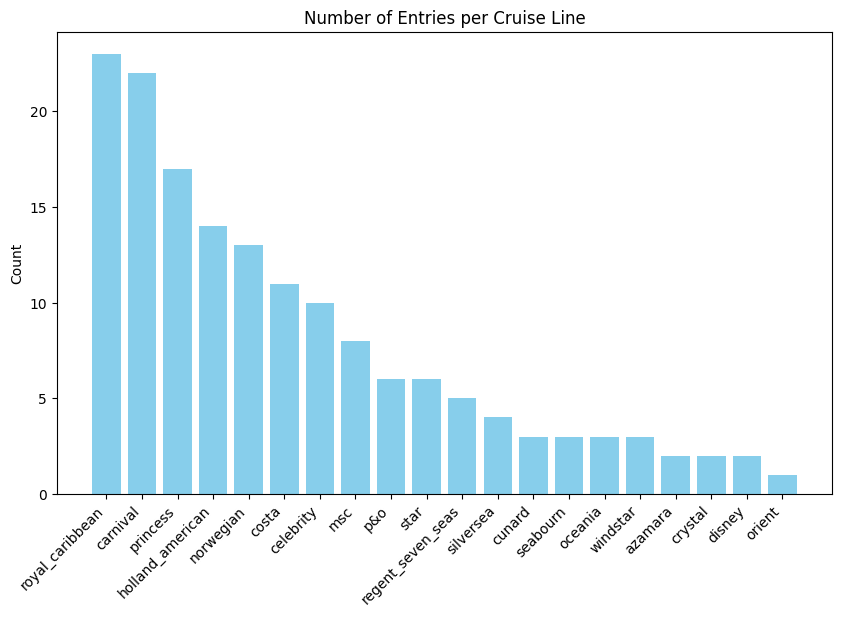

In [1163]:
from pyspark.sql.functions import col, lower
import matplotlib.pyplot as plt

df = df.withColumn("cruise_line", lower(col("cruise_line")))

cruise_counts = df.groupBy("cruise_line").count().orderBy("count", ascending=False)
cruise_counts.show(truncate=False)

cruise_counts_pd = cruise_counts.toPandas()

plt.figure(figsize=(10,6))
plt.bar(cruise_counts_pd['cruise_line'], cruise_counts_pd['count'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')
plt.title('Number of Entries per Cruise Line')
plt.show()

Podemos ver que existen algunas líneas de barcos con representación sumamente baja, en este caso consideramos que dentro de nuestro modelo esto puede generar ruido y predicciones incorrectas. Por ejemplo, puede que el único barco registrado en Orient no siga el mismo patrón que el anterior debido a la muestra tan poco significativa. Decidimos establecer un treshold de 4 para mergear las líneas con menos barcos, de esta manera el modelo puede aprender sobre las tendencias de las líneas con muestras más grandes sin sufrir efectos negativos.

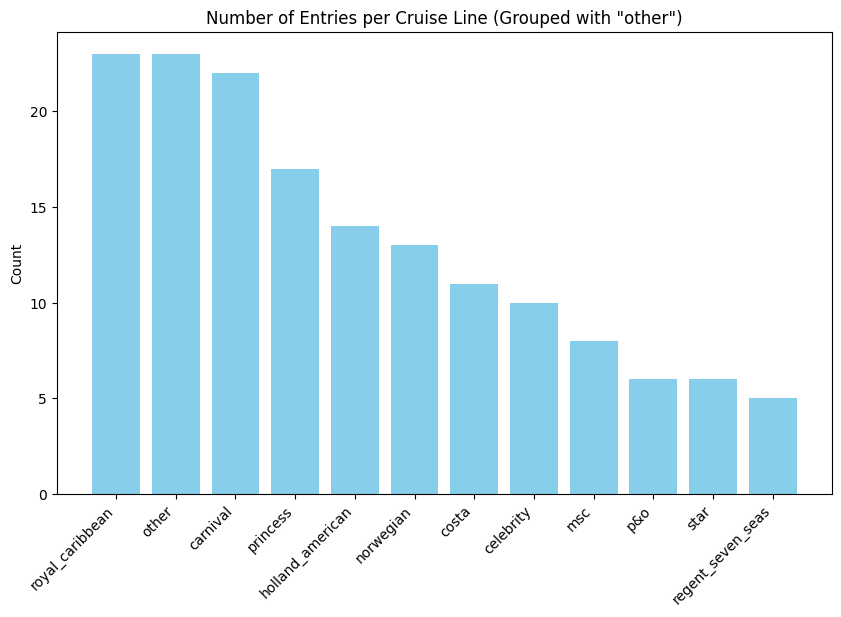

In [1164]:
from pyspark.sql.functions import col, when

threshold = 4

cruise_counts = df.groupBy("cruise_line").count()

low_cruise_lines = cruise_counts.filter(col("count") <= threshold)\
    .select("cruise_line").rdd.flatMap(lambda x: x).collect()

df = df.withColumn(
    "cruise_line",
    when(col("cruise_line").isin(low_cruise_lines), "other").otherwise(col("cruise_line"))
)

grouped_counts = df.groupBy("cruise_line").count().orderBy("count", ascending=False)

grouped_counts_pd = grouped_counts.toPandas()

plt.figure(figsize=(10,6))
plt.bar(grouped_counts_pd['cruise_line'], grouped_counts_pd['count'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')
plt.title('Number of Entries per Cruise Line (Grouped with "other")')
plt.show()

Podemos ver que ahora la distribución cambió ligeramente, dónde tenemos "other" y decidimos mantener únicamente las líneas con un número de barcos de 5 o mayor. Ahora ya podemos explorar un poco más libremente como se relaciona esta variable con nuestra variable respuesta

### Correlación con Variable Objetivo
Para investigar la correlación, podemos realizar Boxplots para las diferentes líneas y comparar como cambian sus distribuciones.

/tmp/ipykernel_9735/1669199311.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


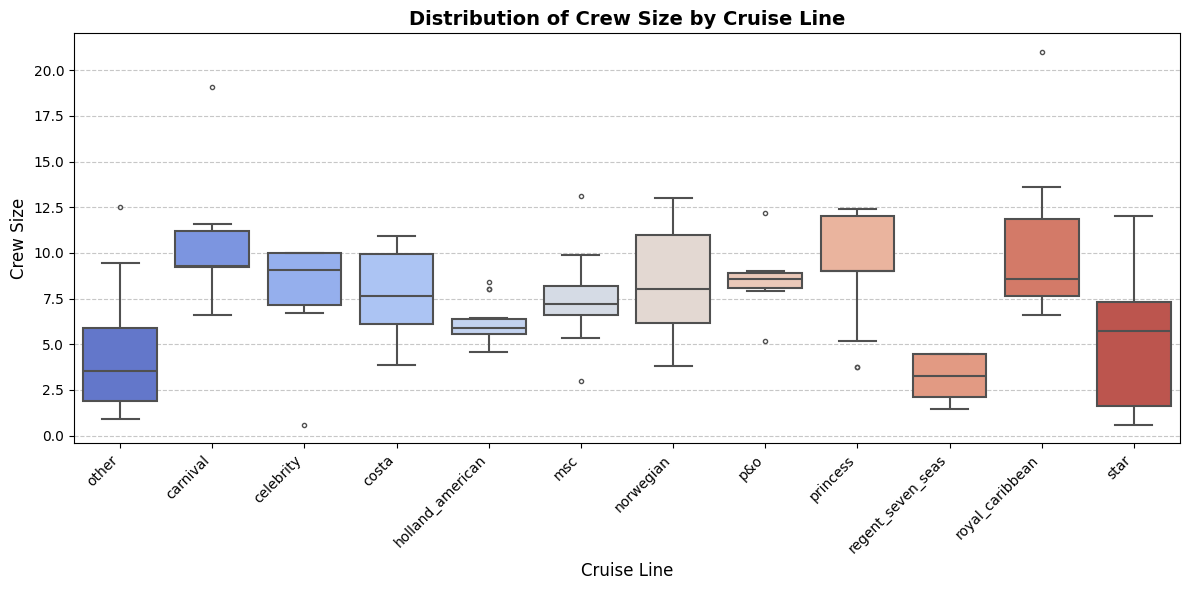

In [1165]:
from pyspark.sql.functions import col, lower
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure the column names are consistent
df = df.withColumn("cruise_line", lower(col("cruise_line")))

# Convert to Pandas (only select relevant columns)
crew_pd = df.select("cruise_line", "crew").toPandas()

# Set up the plot
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=crew_pd,
    x="cruise_line",
    y="crew",
    palette="coolwarm",
    fliersize=3,
    linewidth=1.5
)

plt.title("Distribution of Crew Size by Cruise Line", fontsize=14, fontweight="bold")
plt.xlabel("Cruise Line", fontsize=12)
plt.ylabel("Crew Size", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


Podemos ver que claramente hay variaciones dependiendo de la línea de cruceros. En algunos casos, podemos ver líneas con distribuciones más amplias (cómo "other", dónde es bastante esperado o star dónde se incluye un rango bastante alto) o más angostas (como holland american o p&o). Adicionalmente, las medias pueden variar desde alrededor de 3 hasta 10. Esto nos indica que la línea de cruceros es una variable que puede valer la pena incluir dentro de nuestro modelo.

## Edad

### Distribución

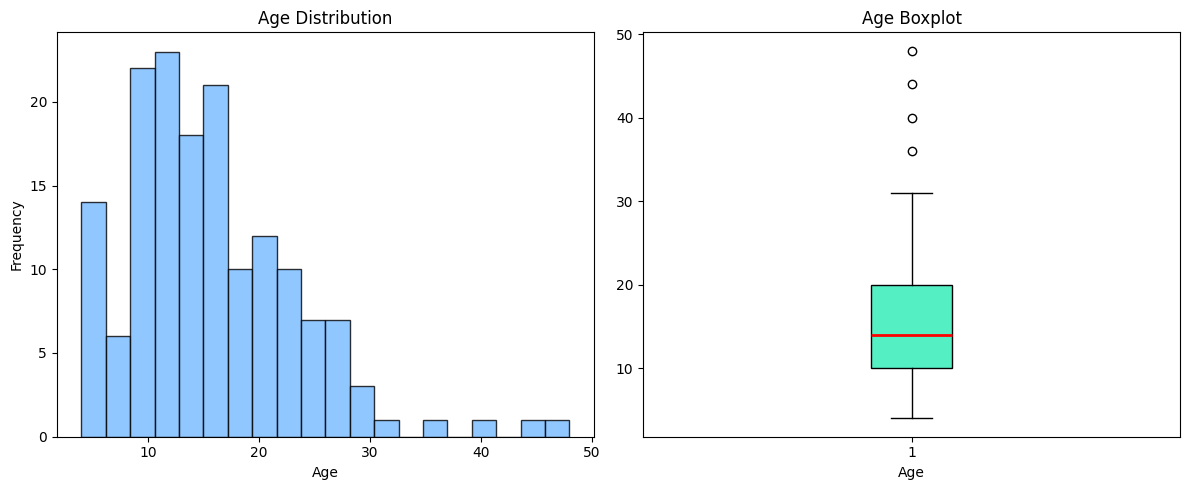

In [1166]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

age_values = df.select(col("age")).rdd.flatMap(lambda x: x).collect()

hist_color = "#74b9ff"
box_color = "#55efc4"

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(age_values, bins=20, color=hist_color, edgecolor="black", alpha=0.8)
axes[0].set_title("Age Distribution")
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Frequency")

axes[1].boxplot(age_values, patch_artist=True,
                boxprops=dict(facecolor=box_color, color="black"),
                medianprops=dict(color="red", linewidth=2))
axes[1].set_title("Age Boxplot")
axes[1].set_xlabel("Age")

plt.tight_layout()
plt.show()

En estas gráficas podemos ver que la antigüedad de los barcos parece tener una distribución similar a la normal (sin embargo, una cola bastante larga hacia la derecha y una acumulación de barcos nuevos anormal), esto es una buena señal para nuestros modelos. Adicionalmente, podemos ver que tenemos algunos barcos que cuentan con edades fuera de lo común. En este caso, al buscar aplicar únicamente una regresión lineal vamos a remover estos valores. Este tipo de modelos es muy sensible a los outliers y buscamos que no se vea afectado por este tipo de valores

In [1167]:
from pyspark.sql.window import Window
from pyspark.sql.functions import col, row_number

w = Window.orderBy(col("age").desc())
df = df.withColumn("row_num", row_number().over(w)).filter(col("row_num") > 4).drop("row_num")

### Correlación con Variable Objetivo

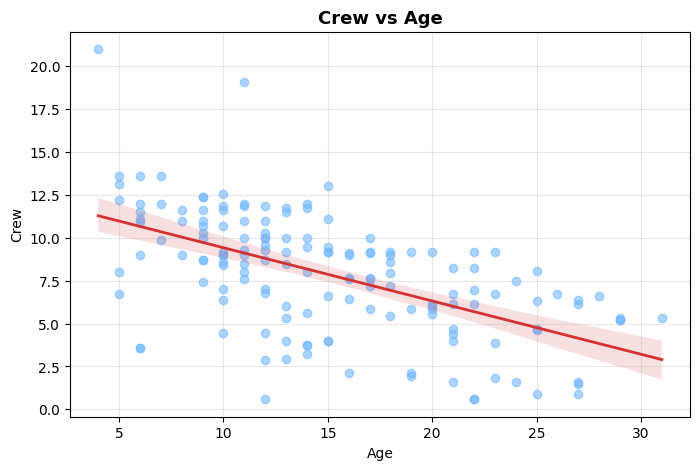

In [1168]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col

age_pd = df.select(col("age"), col("crew")).toPandas()

plt.figure(figsize=(8,5))
sns.regplot(
    data=age_pd,
    x="age",
    y="crew",
    scatter_kws={"alpha":0.6, "color":"#74b9ff"},
    line_kws={"color":"#d63031", "linewidth":2}
)
plt.title("Crew vs Age", fontsize=13, fontweight="bold")
plt.xlabel("Age")
plt.ylabel("Crew")
plt.grid(alpha=0.3)
plt.show()

Podemos ver que existe una relcación bastante clara, dónde los baros más nuevos suelen requerir un crew más grande. Adicionalmente, podemos ver que el margen de error es bastante consistente a lo largo de la gráfica, lo cuál indica que esta variable se correlaciona de manera acorde a los supuestos de la regresión lineal.

## Tonelaje

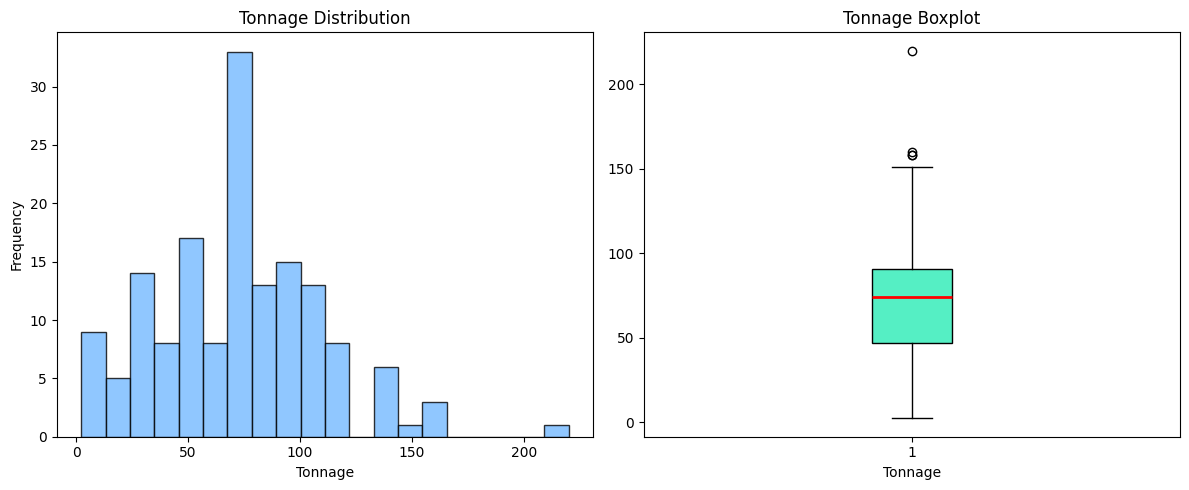

In [1169]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

tonnage_values = df.select(col("tonnage")).rdd.flatMap(lambda x: x).collect()

hist_color = "#74b9ff"
box_color = "#55efc4"

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(tonnage_values, bins=20, color=hist_color, edgecolor="black", alpha=0.8)
axes[0].set_title("Tonnage Distribution")
axes[0].set_xlabel("Tonnage")
axes[0].set_ylabel("Frequency")

axes[1].boxplot(tonnage_values, patch_artist=True,
                boxprops=dict(facecolor=box_color, color="black"),
                medianprops=dict(color="red", linewidth=2))
axes[1].set_title("Tonnage Boxplot")
axes[1].set_xlabel("Tonnage")

plt.tight_layout()
plt.show()


Similar al inciso anterior, aquí podemos ver valores bastante concentrados hacia el centro con algunos valores ligeramente más altos. Adicionalmente, aquí también tenemos outliers dónde el tonelaje es extremadamente alto. El principal outlier es un único barco, por lo que vamos a remover esa entrada.

In [1170]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, col

w = Window.orderBy(col("tonnage").desc())
df = df.withColumn("row_num", row_number().over(w)).filter(col("row_num") > 1).drop("row_num")

### Correlación con Variable Objetivo

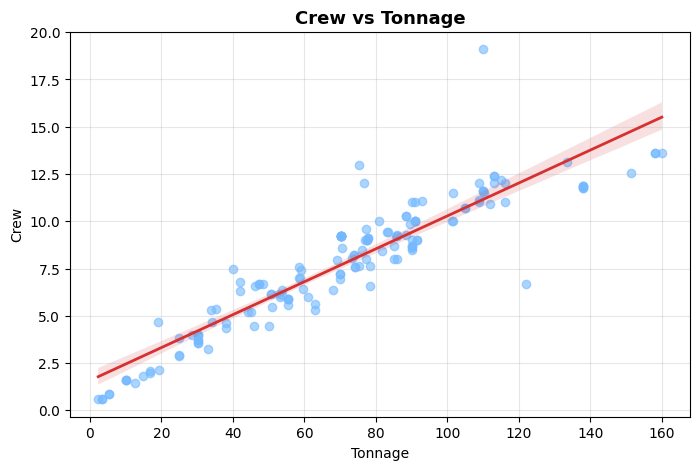

In [1171]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col

tonnage_pd = df.select(col("tonnage"), col("crew")).toPandas()

plt.figure(figsize=(8,5))
sns.regplot(
    data=tonnage_pd,
    x="tonnage",
    y="crew",
    scatter_kws={"alpha":0.6, "color":"#74b9ff"},
    line_kws={"color":"#d63031", "linewidth":2}
)
plt.title("Crew vs Tonnage", fontsize=13, fontweight="bold")
plt.xlabel("Tonnage")
plt.ylabel("Crew")
plt.grid(alpha=0.3)
plt.show()

En este caso, podemos ver una relación que parece ser casi perfecta dentro de la gráfica. Únicamente existen algunos puntos específicos dónde la relación no se cumple, pero para todo el resto de puntos podemos ver que mientras mayor sea el tonelaje se requiere un crew más grande.

## Longitud / Length

### Distribución

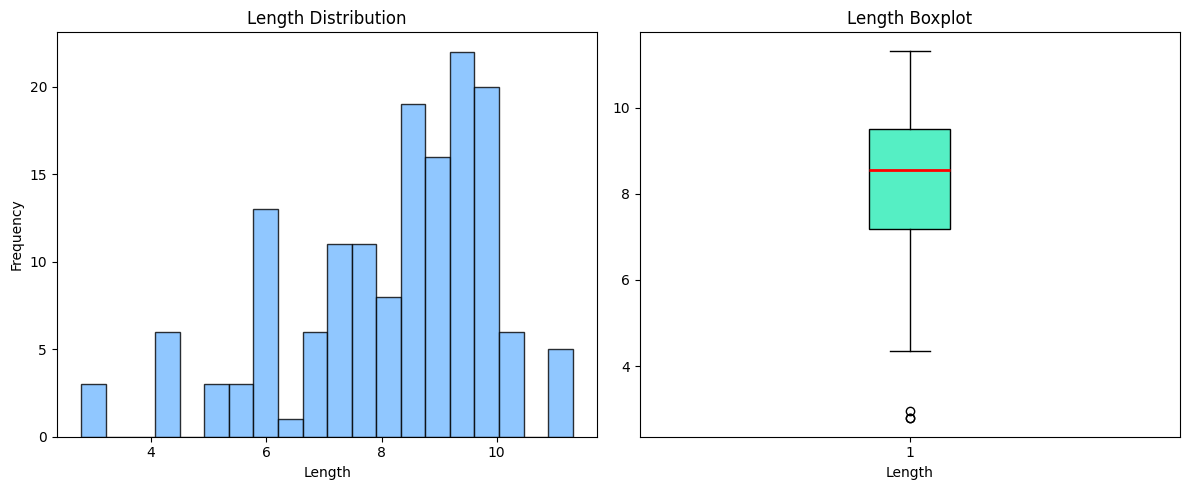

In [1172]:
length_values = df.select(col("length")).rdd.flatMap(lambda x: x).collect()

fig, axes = plt.subplots(1, 2, figsize=(12,5))

axes[0].hist(length_values, bins=20, color=hist_color, edgecolor="black", alpha=0.8)
axes[0].set_title("Length Distribution")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Frequency")

axes[1].boxplot(length_values, patch_artist=True,
                boxprops=dict(facecolor=box_color, color="black"),
                medianprops=dict(color="red", linewidth=2))
axes[1].set_title("Length Boxplot")
axes[1].set_xlabel("Length")

plt.tight_layout()
plt.show()

Para esta variable, podemos observar en el boxplot que no encontramos valores atípicos en cuanto a longitud por el límite superior. Únicamente en el límite inferior encontramos estos valores, dónde buscamos removerlos debido a la diferencia entre estos y los demás. Adicionalmente, la distribución en este caso no parece ser tan cercana a una normal debido a su alto sesgo y longitud de colas poco uniforme. Vamos a remover los 3 valores inferiores para remover los outliers

In [1173]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, col

w = Window.orderBy(col("length").asc())

df = df.withColumn("row_num", row_number().over(w)).filter(col("row_num") > 3).drop("row_num")

df.select("length").orderBy(col("length").asc()).show(5)

+------+
|length|
+------+
|  4.36|
|   4.4|
|   4.4|
|   4.4|
|   4.4|
+------+
only showing top 5 rows


Luego de verificar la eliminación de los outliers, podemos proceder a analizar la correlación con la variable objetivo.

### Relación con Variable Objetivo

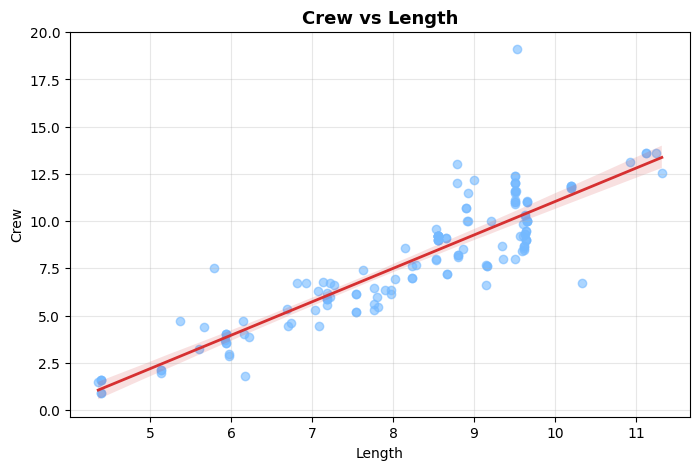

In [1174]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col

length_pd = df.select(col("length"), col("crew")).toPandas()

plt.figure(figsize=(8,5))
sns.regplot(
    data=length_pd,
    x="length",
    y="crew",
    scatter_kws={"alpha":0.6, "color":"#74b9ff"},
    line_kws={"color":"#d63031", "linewidth":2}
)
plt.title("Crew vs Length", fontsize=13, fontweight="bold")
plt.xlabel("Length")
plt.ylabel("Crew")
plt.grid(alpha=0.3)
plt.show()

Podemos ver que claramente existe una relación, mientras mayor la longitud se requiere una tripulación más grande. Sin embargo, podemos ver un ligero cambio en la dispersión de los puntos a lo largo de los diferentes valores de longitud. Específicamente entre 8-10, debemos de tomar en cuenta este tipo de cambios para ubicar dónde pueden suceder errores dentro de la regresión lineal.

## Cabinas

### Distribución

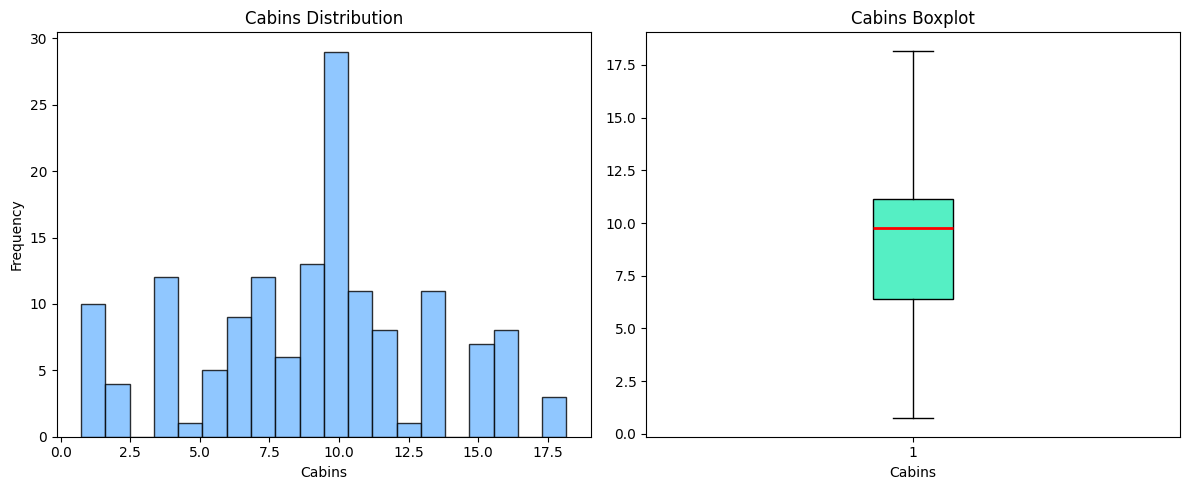

In [1175]:
cabins_values = df.select(col("cabins")).rdd.flatMap(lambda x: x).collect()

fig, axes = plt.subplots(1, 2, figsize=(12,5))

axes[0].hist(cabins_values, bins=20, color=hist_color, edgecolor="black", alpha=0.8)
axes[0].set_title("Cabins Distribution")
axes[0].set_xlabel("Cabins")
axes[0].set_ylabel("Frequency")

axes[1].boxplot(cabins_values, patch_artist=True,
                boxprops=dict(facecolor=box_color, color="black"),
                medianprops=dict(color="red", linewidth=2))
axes[1].set_title("Cabins Boxplot")
axes[1].set_xlabel("Cabins")

plt.tight_layout()
plt.show()

En este caso podemos ver que la cantidad de cabinas se distribuye de una forma bastante particular. Hasta cierto punto, parece ser algo uniforme excepto por la cantidad de 10 cabinas. Adicionalmente, el boxplot indica que no tenemos outliers. Podemos proceder a explorar la relación que tiene con nuestra variable objetivo.

### Correlación con Variable Objetivo

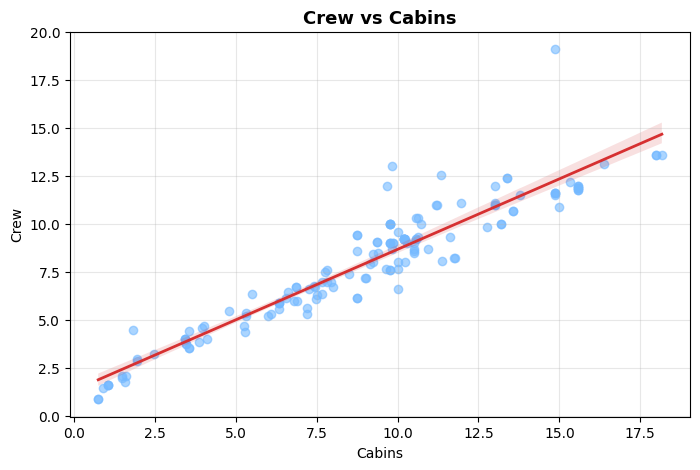

In [1176]:
cabins_pd = df.select(col("cabins"), col("crew")).toPandas()

plt.figure(figsize=(8,5))
sns.regplot(
    data=cabins_pd,
    x="cabins",
    y="crew",
    scatter_kws={"alpha":0.6, "color":"#74b9ff"},
    line_kws={"color":"#d63031", "linewidth":2}
)
plt.title("Crew vs Cabins", fontsize=13, fontweight="bold")
plt.xlabel("Cabins")
plt.ylabel("Crew")
plt.grid(alpha=0.3)
plt.show()


Aquí podemos ver un caso similar al anterior, la relación es bastante clara y tiene total sentido. Mientras más cabinas, se necesita una tripulación más grande a bordo. Sin embargo, podemos ver que igual al anterior tenemos puntos dónde la dispersión es más grande que en los demás.

## Pasajeros

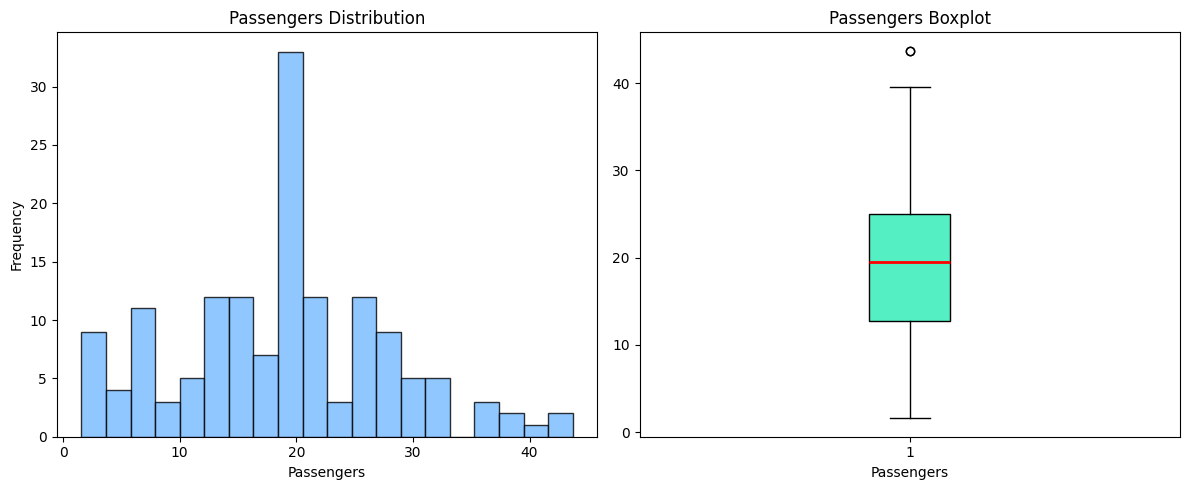

In [1177]:
passengers_values = df.select(col("passengers")).rdd.flatMap(lambda x: x).collect()

fig, axes = plt.subplots(1, 2, figsize=(12,5))

axes[0].hist(passengers_values, bins=20, color=hist_color, edgecolor="black", alpha=0.8)
axes[0].set_title("Passengers Distribution")
axes[0].set_xlabel("Passengers")
axes[0].set_ylabel("Frequency")

axes[1].boxplot(passengers_values, patch_artist=True,
                boxprops=dict(facecolor=box_color, color="black"),
                medianprops=dict(color="red", linewidth=2))
axes[1].set_title("Passengers Boxplot")
axes[1].set_xlabel("Passengers")

plt.tight_layout()
plt.show()

Podemos darnos cuenta que la distribución es bastante parecida a la de las cabinas, lo cual tiene bastante sentido. Entre más cabinas más pasajeros y una tripulación más grande. Debido a esto, tenemos que tener cuidado con la colinealidad de estas variables. Cuando estemos tratando con los modelos, podemos tener esto en mente.

## Correlación con Variable Objetivo

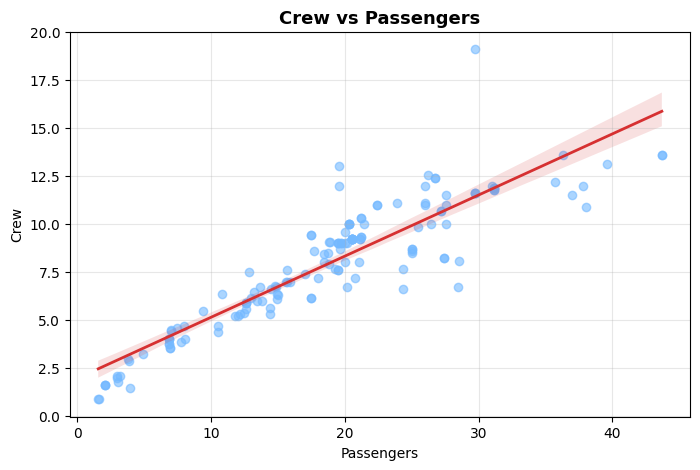

In [1178]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col

passengers_pd = df.select(col("passengers"), col("crew")).toPandas()

plt.figure(figsize=(8,5))
sns.regplot(
    data=passengers_pd,
    x="passengers",
    y="crew",
    scatter_kws={"alpha":0.6, "color":"#74b9ff"},
    line_kws={"color":"#d63031", "linewidth":2}
)
plt.title("Crew vs Passengers", fontsize=13, fontweight="bold")
plt.xlabel("Passengers")
plt.ylabel("Crew")
plt.grid(alpha=0.3)
plt.show()

Podemos ver resultados bastante similares, por lo que debemos de tomar una decisión en los modelos. Podríamos retirar una de estas variables o convertirlas en una por medio de PCA.

## Densidad de Pasajeros

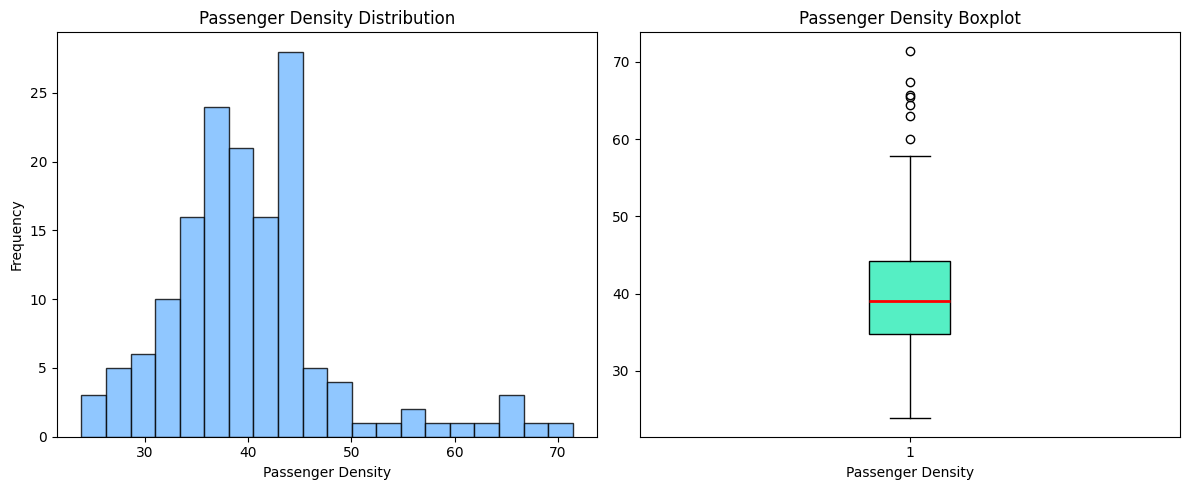

In [1179]:
density_values = df.select(col("passenger_density")).rdd.flatMap(lambda x: x).collect()

fig, axes = plt.subplots(1, 2, figsize=(12,5))

axes[0].hist(density_values, bins=20, color=hist_color, edgecolor="black", alpha=0.8)
axes[0].set_title("Passenger Density Distribution")
axes[0].set_xlabel("Passenger Density")
axes[0].set_ylabel("Frequency")

axes[1].boxplot(density_values, patch_artist=True,
                boxprops=dict(facecolor=box_color, color="black"),
                medianprops=dict(color="red", linewidth=2))
axes[1].set_title("Passenger Density Boxplot")
axes[1].set_xlabel("Passenger Density")

plt.tight_layout()
plt.show()

La densidad de pasajeros parece seguir una distribución normal con una cola derecha bastante pequeña. Adicionalmente, tenemos algunos barcos con una densidad de pasajeros bastante grande. En este caso, decidimos ignorar los outliers ya que los valores son bastante variados y consideramos que todavía quedan "dentro de rango" para este proyecto.

### Correlación con Variable Objetivo

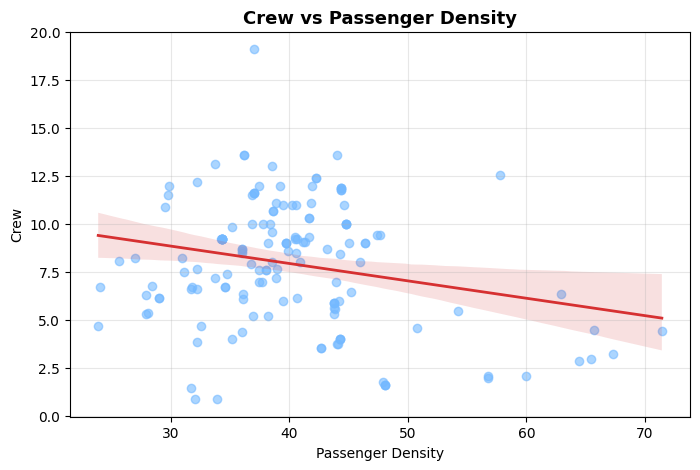

In [1180]:
density_pd = df.select(col("passenger_density"), col("crew")).toPandas()

plt.figure(figsize=(8,5))
sns.regplot(
    data=density_pd,
    x="passenger_density",
    y="crew",
    scatter_kws={"alpha":0.6, "color":"#74b9ff"},
    line_kws={"color":"#d63031", "linewidth":2}
)
plt.title("Crew vs Passenger Density", fontsize=13, fontweight="bold")
plt.xlabel("Passenger Density")
plt.ylabel("Crew")
plt.grid(alpha=0.3)
plt.show()


Aquí podemos observar que parece no existir correlación, es bastante "flojo" el ajuste al modelo lineal y realmente no podríamos incluir esta variable dentro de los modelos. En este caso, decidimos simplemente no incluirla ya que probablemente pueda ajustarse a otros tipos de modelos.

## Crew

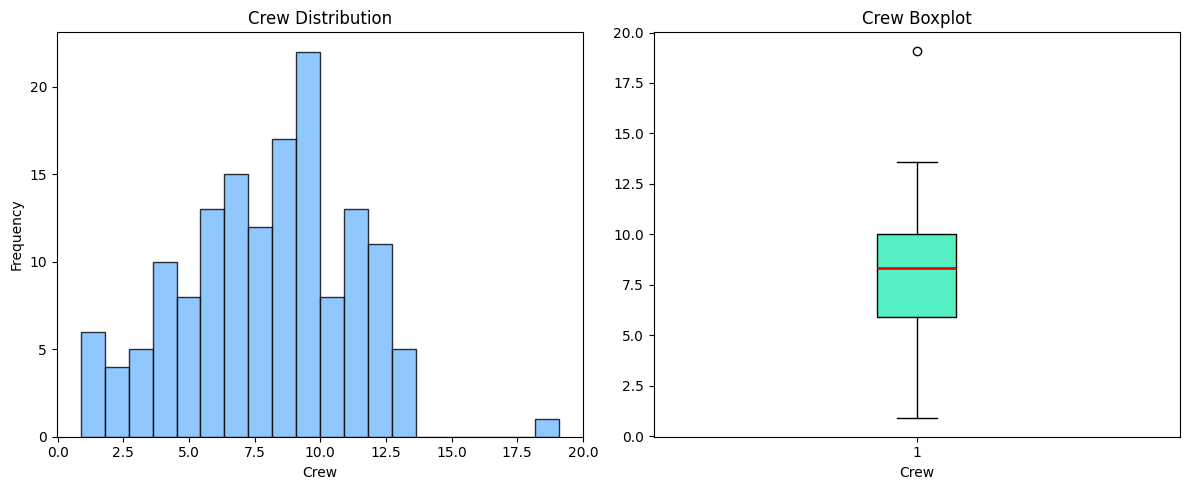

In [1181]:
crew_values = df.select(col("crew")).rdd.flatMap(lambda x: x).collect()

fig, axes = plt.subplots(1, 2, figsize=(12,5))

axes[0].hist(crew_values, bins=20, color=hist_color, edgecolor="black", alpha=0.8)
axes[0].set_title("Crew Distribution")
axes[0].set_xlabel("Crew")
axes[0].set_ylabel("Frequency")

axes[1].boxplot(crew_values, patch_artist=True,
                boxprops=dict(facecolor=box_color, color="black"),
                medianprops=dict(color="red", linewidth=2))
axes[1].set_title("Crew Boxplot")
axes[1].set_xlabel("Crew")

plt.tight_layout()
plt.show()

Aquí podemos ver que sigue una distribución bastante normal, sin embargo tenemos un outlier muy por encima de los demás. En este caso, debido al modelo a implementar, decidimos removerlo para entrenarlo exclusivamente con datos más "típicos".

In [1182]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, col

w = Window.orderBy(col("crew").desc())

df = df.withColumn("row_num", row_number().over(w)).filter(col("row_num") > 1).drop("row_num")

df.select("crew").orderBy(col("crew").desc()).show(5)

+-----+
| crew|
+-----+
| 13.6|
| 13.6|
| 13.6|
|13.13|
| 13.0|
+-----+
only showing top 5 rows


## One-Hot-Encoding

En este caso no podemos utilizar el OHE de SKLearn, sin embargo PySpark nos provee una funcionalidad similar. En este caso, vamos a encodearlos en una manera que los modelos de SparkML "entiendan". Aquí básicamente reemplazamos la columna de cruise_line por su representación en "sparse vector", dónde en términos prácticos es un one hot encode dentro de un vector.

In [1183]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

indexer = StringIndexer(inputCol="cruise_line", outputCol="cruise_line_index")

encoder = OneHotEncoder(inputCols=["cruise_line_index"], outputCols=["cruise_line_encoded"])

pipeline = Pipeline(stages=[indexer, encoder])

df = pipeline.fit(df).transform(df)

df = df.drop("cruise_line", "cruise_line_index")

df = df.withColumnRenamed("cruise_line_encoded", "cruise_line")

df.select("cruise_line").show(5, truncate=False)

+--------------+
|cruise_line   |
+--------------+
|(11,[0],[1.0])|
|(11,[0],[1.0])|
|(11,[0],[1.0])|
|(11,[8],[1.0])|
|(11,[5],[1.0])|
+--------------+
only showing top 5 rows


## Análisis de Correlación

Matriz de Correlación:
--------------------------------------------------------------------------------
Variable            age            tonnage        passengers     length         cabins         passenger_densitycrew           
--------------------------------------------------------------------------------------------------------------------------------------------
age                 1.0000         -0.6433        -0.5441        -0.6006        -0.5339        -0.2262        -0.5708        
tonnage             -0.6433        1.0000         0.9350         0.9355         0.9368         -0.1005        0.9275         
passengers          -0.5441        0.9350         1.0000         0.8859         0.9726         -0.3754        0.9134         
length              -0.6006        0.9355         0.8859         1.0000         0.8942         -0.1501        0.9118         
cabins              -0.5339        0.9368         0.9726         0.8942         1.0000         -0.3411        0.9523       

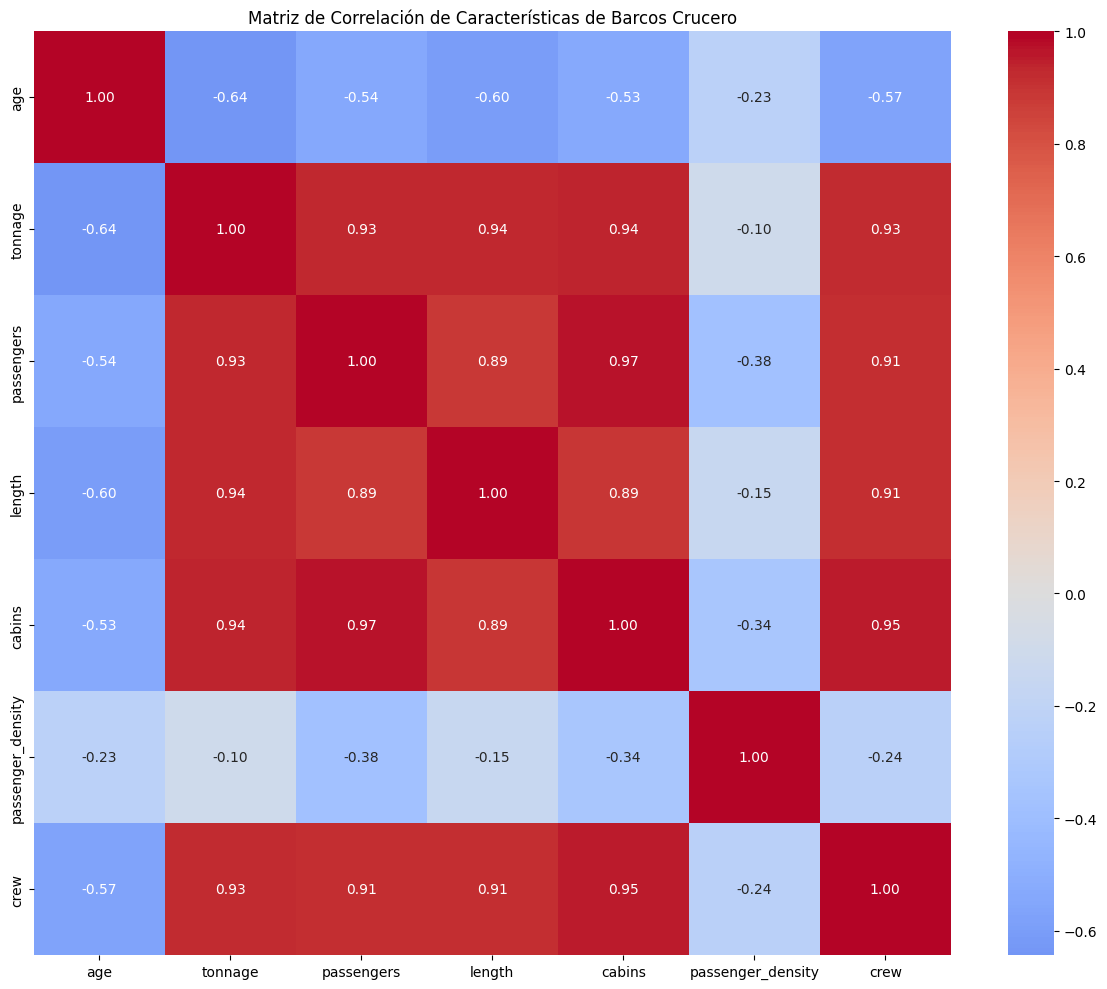

In [1184]:
correlation_cols = ["age", "tonnage", "passengers", "length", "cabins", "passenger_density", "crew"]

print("Matriz de Correlación:")
print("-" * 80)

correlation_matrix = {}

for col1 in correlation_cols:
    correlation_matrix[col1] = {}
    for col2 in correlation_cols:
        if col1 == col2:
            correlation_matrix[col1][col2] = 1.0
        else:
            corr = df.stat.corr(col1, col2)
            correlation_matrix[col1][col2] = corr

print(f"{'Variable':<20}", end="")
for col in correlation_cols:
    print(f"{col:<15}", end="")
print()
print("-" * 140)

for col1 in correlation_cols:
    print(f"{col1:<20}", end="")
    for col2 in correlation_cols:
        print(f"{correlation_matrix[col1][col2]:<15.4f}", end="")
    print()

import numpy as np
corr_array = np.array([[correlation_matrix[col1][col2] for col2 in correlation_cols] 
                       for col1 in correlation_cols])

plt.figure(figsize=(12, 10))
sns.heatmap(corr_array, annot=True, cmap="coolwarm", center=0, fmt=".2f",
            xticklabels=correlation_cols, yticklabels=correlation_cols)
plt.title("Matriz de Correlación de Características de Barcos Crucero")
plt.tight_layout()
plt.show()

Aquí podemos ver algunas cosas interesantes, empezando por la densidad de pasajeros. Aquí tuvimos bastante razón indicando que no parecía correlacionarse con la cantidad de crew, y realmente no parece tener una correlación tan fuerte con algunas de las otras variables. Debido a esto, vamos a eliminarla. Luego, Tonnage, Passengers, Length y Cabins tienen una alta correlación con la variable objetivo. Antes de analizar sobre la colinealidad, vamos a crear un modelo baseline para tener comparación a lo largo de los cambios realizados.

# Modelos

## Train / Test
Antes de iniciar con los modelos, vamos a separar nuestros conjuntos de entrenamiento y prueba. Aquí PySpark nos ofrece una manera muy sencilla de hacerlo.

In [1185]:
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

print(f"Train rows: {train_df.count()}, Test rows: {test_df.count()}")

Train rows: 125, Test rows: 24


## Baseline
Este modelo incluye todas las variables, menos passenger density por razones previamente explicadas. Aquí principalmente vamos a establecer un punto de partida antes de continuar.

### Entrenamiento

In [1186]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline

numeric_cols = ["age", "tonnage", "passengers", "length", "cabins"]
ohe_col = "cruise_line"

assembler = VectorAssembler(inputCols=numeric_cols + [ohe_col], outputCol="features_raw")

scaler = StandardScaler(inputCol="features_raw", outputCol="features", withMean=True, withStd=True)

lr = LinearRegression(featuresCol="features", labelCol="crew")

pipeline = Pipeline(stages=[assembler, scaler, lr])

lr_model = pipeline.fit(train_df)

### Predicciones y Resultados

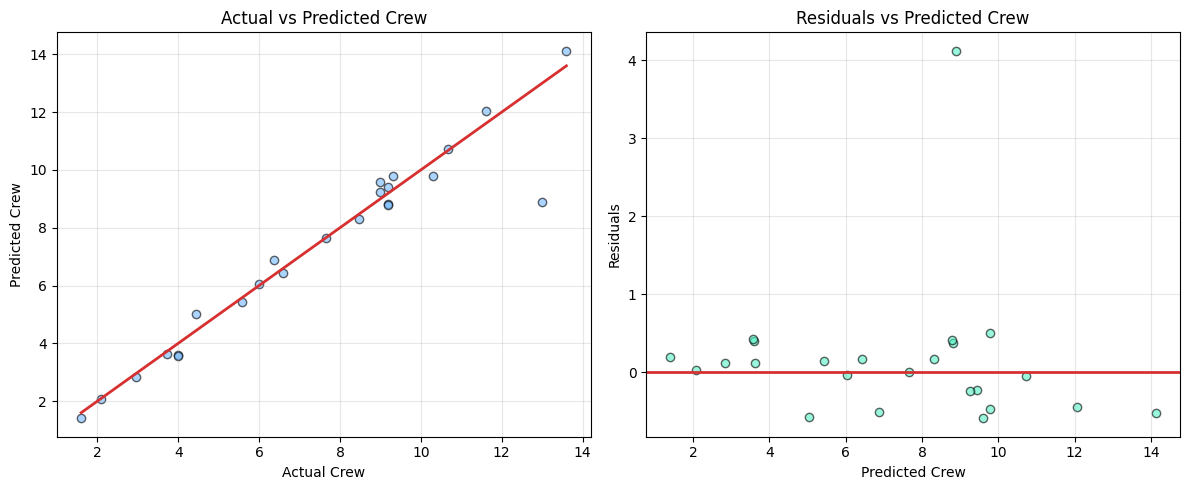

Test RMSE: 0.91
Test R²: 0.92


In [1187]:
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import RegressionEvaluator

predictions = lr_model.transform(test_df)

pred_pd = predictions.select("crew", "prediction").toPandas()
pred_pd["residuals"] = pred_pd["crew"] - pred_pd["prediction"]

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(pred_pd["crew"], pred_pd["prediction"], alpha=0.6, color="#74b9ff", edgecolor="k")
plt.plot([pred_pd["crew"].min(), pred_pd["crew"].max()],
         [pred_pd["crew"].min(), pred_pd["crew"].max()],
         color="#d63031", linewidth=2)
plt.xlabel("Actual Crew")
plt.ylabel("Predicted Crew")
plt.title("Actual vs Predicted Crew")
plt.grid(alpha=0.3)

plt.subplot(1,2,2)
plt.scatter(pred_pd["prediction"], pred_pd["residuals"], alpha=0.6, color="#55efc4", edgecolor="k")
plt.axhline(0, color="#d63031", linewidth=2)
plt.xlabel("Predicted Crew")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Crew")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

evaluator_rmse = RegressionEvaluator(labelCol="crew", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)

evaluator_r2 = RegressionEvaluator(labelCol="crew", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²: {r2:.2f}")


Aquí podemos ver que el modelo baseline en realidad es bastante bueno, tenemos un R2 de 0.92. Esto quiere decir que un 92% de los errores que comete el modelo se pueden explicar "naturalmente" debido a la varianza. Adicionalmente, viendo la gráfica de real vs predicciones el modelo se encuentra bastante cerca de la línea del centro. Adicionalmente, en la gráfica de residuales podemos ver una dispersión bastante uniforme. Únicamente tenemos un punto de los datos que se encuentra bastante por encima, dónde un barco tiene un crew mucho menor de lo que fue predicho.

## PCA
En los siguientes modelos buscamos evitar ciertos errores que puedan existir debido a la colinealidad de las variables. Dónde por ejemplo, length y tonnage pueden crear un "size factor" mientras que cabins y passengers un "capacity factor" para intentar predecir. Buscamos experimentar y averiguar si el modelo puede mejorarse para tomar una decisión informada.

### Creación de Size Factor

In [1188]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA

assembler = VectorAssembler(inputCols=["length", "tonnage"], outputCol="size_vector")
df = assembler.transform(df)

scaler = StandardScaler(inputCol="size_vector", outputCol="size_scaled", withMean=True, withStd=True)
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

pca = PCA(k=1, inputCol="size_scaled", outputCol="size_component")
pca_model = pca.fit(df)
df = pca_model.transform(df)

df = df.drop("size_vector", "size_scaled")

train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

df.select("length", "tonnage", "cabins", "size_component").show(5, truncate=False)

+------+-----------------+------+---------------------+
|length|tonnage          |cabins|size_component       |
+------+-----------------+------+---------------------+
|11.12 |160.0            |18.17 |[-3.075248636603786] |
|11.12 |158.0            |18.0  |[-3.0338323297466436]|
|11.25 |158.0            |18.0  |[-3.0906797152204692]|
|10.93 |133.5            |16.37 |[-2.4433979304387483]|
|8.79  |75.33800000000001|9.83  |[-0.3031748883109014]|
+------+-----------------+------+---------------------+
only showing top 5 rows


### Entrenamiento del Modelo

In [1189]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import RegressionEvaluator

feature_cols = ["size_component", "cabins", "passengers", "age", "cruise_line"]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_raw")
scaler = StandardScaler(inputCol="features_raw", outputCol="features", withMean=True, withStd=True)
lr = LinearRegression(featuresCol="features", labelCol="crew")
pipeline = Pipeline(stages=[assembler, scaler, lr])

lr_model = pipeline.fit(train_df)

predictions = lr_model.transform(test_df)

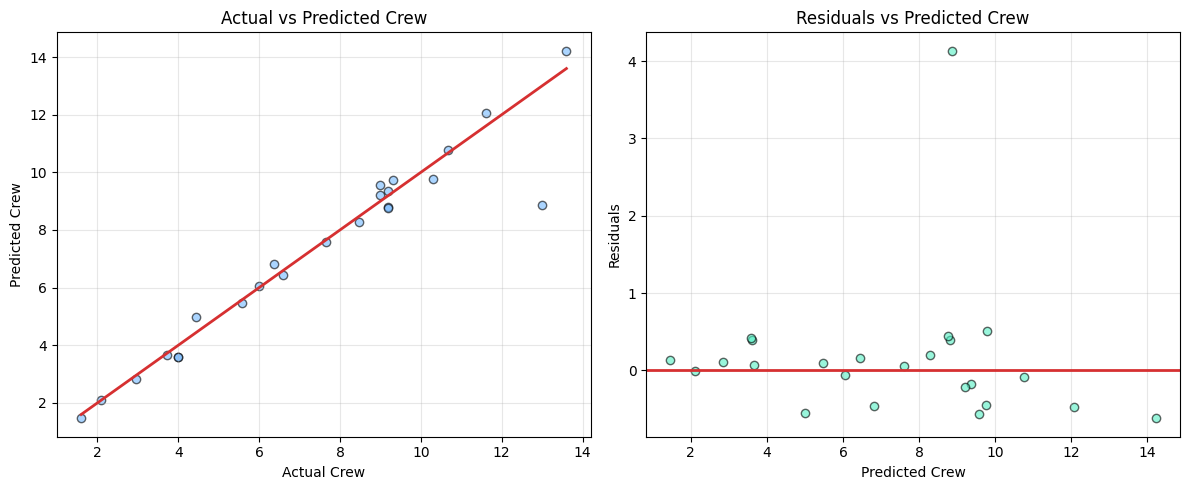

Test RMSE: 0.91
Test R²: 0.92


In [1190]:
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import RegressionEvaluator

predictions = lr_model.transform(test_df)

pred_pd = predictions.select("crew", "prediction").toPandas()
pred_pd["residuals"] = pred_pd["crew"] - pred_pd["prediction"]

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(pred_pd["crew"], pred_pd["prediction"], alpha=0.6, color="#74b9ff", edgecolor="k")
plt.plot([pred_pd["crew"].min(), pred_pd["crew"].max()],
         [pred_pd["crew"].min(), pred_pd["crew"].max()],
         color="#d63031", linewidth=2)
plt.xlabel("Actual Crew")
plt.ylabel("Predicted Crew")
plt.title("Actual vs Predicted Crew")
plt.grid(alpha=0.3)

plt.subplot(1,2,2)
plt.scatter(pred_pd["prediction"], pred_pd["residuals"], alpha=0.6, color="#55efc4", edgecolor="k")
plt.axhline(0, color="#d63031", linewidth=2)
plt.xlabel("Predicted Crew")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Crew")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

rmse = RegressionEvaluator(labelCol="crew", predictionCol="prediction", metricName="rmse").evaluate(predictions)
r2 = RegressionEvaluator(labelCol="crew", predictionCol="prediction", metricName="r2").evaluate(predictions)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²: {r2:.2f}")


El rendimiento del modelo es bastante similar al anterior, de hecho hasta las predicciones en la gráfica de residuales son difíciles de distinguir entre ambos. Podríamos decir que ambos modelos son equivalentes realmente, por lo que vamos a comprobar agregando el factor capacidad para intentar conseguir un modelo aún mejor.

### Creación Capacity Factor

In [1191]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA

for col_name in ["size_component", "capacity_component"]:
    if col_name in df.columns:
        df = df.drop(col_name)

assembler_size = VectorAssembler(inputCols=["length", "tonnage", "cabins"], outputCol="size_vector")
df = assembler_size.transform(df)

scaler_size = StandardScaler(inputCol="size_vector", outputCol="size_scaled", withMean=True, withStd=True)
scaler_model_size = scaler_size.fit(df)
df = scaler_model_size.transform(df)

pca_size = PCA(k=1, inputCol="size_scaled", outputCol="size_component")
pca_model_size = pca_size.fit(df)
df = pca_model_size.transform(df)
df = df.drop("size_vector", "size_scaled")

assembler_capacity = VectorAssembler(inputCols=["cabins", "passengers"], outputCol="capacity_vector")
df = assembler_capacity.transform(df)

scaler_capacity = StandardScaler(inputCol="capacity_vector", outputCol="capacity_scaled", withMean=True, withStd=True)
scaler_model_capacity = scaler_capacity.fit(df)
df = scaler_model_capacity.transform(df)

pca_capacity = PCA(k=1, inputCol="capacity_scaled", outputCol="capacity_component")
pca_model_capacity = pca_capacity.fit(df)
df = pca_model_capacity.transform(df)
df = df.drop("capacity_vector", "capacity_scaled")

train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

df.select("size_component", "capacity_component", "age").show(5, truncate=False)

+---------------------+----------------------+---+
|size_component       |capacity_component    |age|
+---------------------+----------------------+---+
|[-3.815633811243928] |[-2.973478812109594]  |5  |
|[-3.757647664027746] |[-3.5189721622000443] |7  |
|[-3.803818321951228] |[-3.5189721622000443] |6  |
|[-3.043272467273053] |[-2.9167688466969723] |5  |
|[-0.3731641598453936]|[-0.22412329018344723]|15 |
+---------------------+----------------------+---+
only showing top 5 rows


In [1192]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline

feature_cols = ["size_component", "capacity_component", "age", "cruise_line"]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_raw")
scaler = StandardScaler(inputCol="features_raw", outputCol="features", withMean=True, withStd=True)
lr = LinearRegression(featuresCol="features", labelCol="crew")
pipeline = Pipeline(stages=[assembler, scaler, lr])

lr_model = pipeline.fit(train_df)

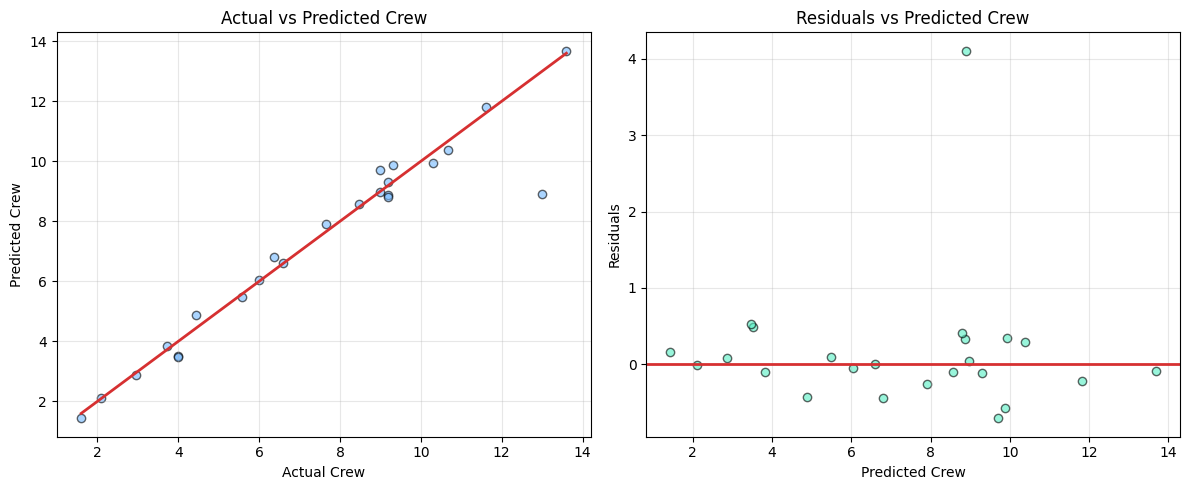

Test RMSE: 0.90
Test R²: 0.93


In [1193]:
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import RegressionEvaluator

predictions = lr_model.transform(test_df)

pred_pd = predictions.select(
    predictions["crew"].cast("double").alias("crew"),
    predictions["prediction"].cast("double").alias("prediction")
).toPandas()

pred_pd["residuals"] = pred_pd["crew"] - pred_pd["prediction"]

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(pred_pd["crew"], pred_pd["prediction"], alpha=0.6, color="#74b9ff", edgecolor="k")
plt.plot([pred_pd["crew"].min(), pred_pd["crew"].max()],
         [pred_pd["crew"].min(), pred_pd["crew"].max()],
         color="#d63031", linewidth=2)
plt.xlabel("Actual Crew")
plt.ylabel("Predicted Crew")
plt.title("Actual vs Predicted Crew")
plt.grid(alpha=0.3)

plt.subplot(1,2,2)
plt.scatter(pred_pd["prediction"], pred_pd["residuals"], alpha=0.6, color="#55efc4", edgecolor="k")
plt.axhline(0, color="#d63031", linewidth=2)
plt.xlabel("Predicted Crew")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Crew")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

rmse = RegressionEvaluator(labelCol="crew", predictionCol="prediction", metricName="rmse").evaluate(predictions)
r2 = RegressionEvaluator(labelCol="crew", predictionCol="prediction", metricName="r2").evaluate(predictions)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²: {r2:.2f}")


A pesar que todos los modelos fueron bastante buenos, en cuanto a métricas este es el mejor. Cuenta con el mejor RMSE al igual que un R2 de 0.93. Esto en realidad puede parecer poco, pero obtener esas últimas mejoras en los modelos es bastante difícil. Esto nos puede confirmar que el modelo realmente no necesitaba un PCA, si no que dos sets de features combinados para alcanzar una precisión superior. Luego del primer "size factor", todavía seguía existiendo la colinealidad y el modelo estaba sufriendo igualmente. Aquí logramos evitar casi completamente esa colinealidad. Adicionalmente, interpretando un poco más las gráficas el modelo fue sumamente preciso y la mayoría de residuales están extremadamente cerca del 0. Además, el spread que encontramos es uniforme a lo largo de la gráfica y únicamente tuvimos una predicción bastante errónea. Esta fue la misma que estuvo bastante distante en los modelos anteriores.

# Resultados

## Mejor Modelo

El mejor modelo en este caso fue el modeo luego de implementar dos columnas nuevas utilizando PCA. Durante el análisis exploratorio encontramos colinealidad e identificamos esta posible dificultad para el modelo. Gracias a eso, logramos que el modelo tuviera un rendimiento ligeramente mejor. Este modelo tuvo un R2 de 0.93 y un RMSE de 0.90. Esto nos quiere decir que en promedio nuestro modelo es capaz de predecir la tripulación con un error promedio de 90 personas. Esto puede parecer bastante, pero hay que tomar en cuenta que las tripulaciones típicas al menos en estos cruceros es entre 100-1400 personas.

## Conclusiones
El análisis exploratorio permitió identificar correlaciones entre distintas variables, así como detectar posibles casos de colinealidad que podrían afectar la interpretación del modelo. Es fundamental comprender los supuestos de los modelos de regresión para distinguir qué variables realmente aportan información relevante y cuáles pueden generar confusión o redundancia. En este sentido, el uso de PCA resultó especialmente útil para resumir la información de variables altamente correlacionadas, como el tamaño de la embarcación (tonnage, length, cabins) y la capacidad de pasajeros, reduciendo la dimensionalidad sin perder demasiada información. Aunque en este caso las relaciones fueron relativamente evidentes (por ejemplo, más cabinas suelen implicar más pasajeros), en escenarios más complejos podría ser necesario consultar con expertos en la materia para interpretar correctamente las relaciones y garantizar que las transformaciones aplicadas mantengan sentido práctico y teórico. Finalmente, combinar la exploración visual de los datos con métricas de ajuste y diagnóstico de residuos asegura que el modelo sea robusto, interpretable y confiable para la predicción.

In [1194]:
spark.stop()